Solve the 1D Poisson equation, written in the form $∂^2Φ/∂x^2 = 1$, on a regular grid of 101 points with finite differences and visualize the solution. The model length is 1000 km. Use sparse initialization for the matrix of coefficients {L}, i.e. L = sparse(101,101). Compose a matrix {L} and a right hand side vector {R} (use Eqs. 3.4–3.7 as an example) and obtain the solution vector {S} with a direct solver (in MATLAB with the command S = L\R). Use Φ = 0 as the boundary condition for the two external nodes of the grid (e.g. Fig. 3.3).

In [3]:
# Import necessary packages
using PyPlot
using SparseArrays
using LinearAlgebra
using Pardiso

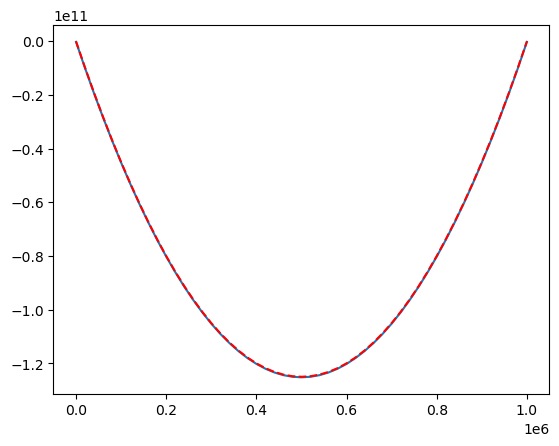

In [4]:
width = 1e6 # width in meters
nx = 51
dx = width/(nx-1) # grid spacing

# create vectors to hold indices and values for poisson operator
row_index = zeros(Int64,3*(nx-2)+2)
col_index = zeros(Int64,3*(nx-2)+2)
values = zeros(Float64, 3*(nx-2)+2)
R = zeros(Float64,nx,1)

#row 1
R[1] = 1
ind = 1
values[ind]    = -2/dx^2
row_index[ind] = 1
col_index[ind] = 1
ind += 1
for node in range(2,nx-1)
    # entry that goes in L[i,j-1]
    row_index[ind] = node
    col_index[ind] = node-1
    values[ind] = 1/dx^2
    ind += 1
    row_index[ind] = node
    col_index[ind] = node
    values[ind] = -2/dx^2
    ind += 1
    row_index[ind] = node
    col_index[ind] = node+1
    values[ind] = 1/dx^2
    ind += 1
    R[node] = 1.0
end
# last row
row_index[ind] = nx
col_index[ind] = nx
values[ind] = -2/dx^2
R[nx] = 1.0
# Form a sparse matrix
L = sparse(row_index,col_index,values);
# Use left divide to compute a solution:
solution = L\R;

x = LinRange(0,width,nx)
y_exact = 0.5*x.^2 -0.5*width*x

figure()
plot(LinRange(0,width,nx),solution,label="numerical")
plot(x,y_exact,"r--",label="analytic")
show()

# Problem 3.2 - solve the 2D poission equation

$$
\frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} = 1
$$

with the Dirichlet boundary condition f=0.

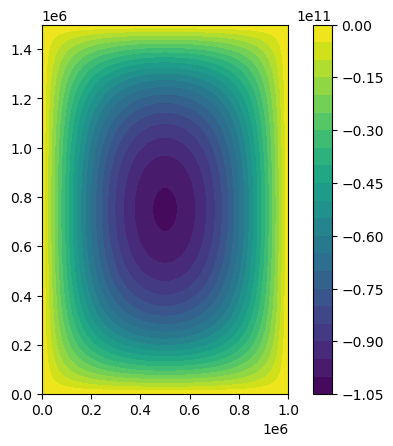

 16.446641 seconds (73 allocations: 2.981 GiB, 1.81% gc time)


In [14]:
# define an indexing function that maps from (i,j) node numbering to an integer index
nx = 1001
ny = 1501
width = 1e6
height = 1.5e6
dx = width/(nx-1)
dy = height/(ny-1)
nn = nx*ny

dof(i::Int64,j::Int64) = (j-1)*ny + i # Gerya 3.22

# pre-allocate arrays to store indices and values
row_index = zeros(Int64,5*nn) # up to 5 nonzeros per row
col_index = zeros(Int64,5*nn)
values = zeros(Float64, 5*nn)
R = zeros(Float64,nn,1)
k=1
for i in 1:ny
    for j in 1:nx
        row = dof(i,j)
        coef_center = -2/dx^2-2/dy^2
        coef_right = 1/dx^2
        coef_left = 1/dx^2
        coef_up = 1/dy^2
        coef_down = 1/dy^2
        # modify equations for dirichlet boundary condition f=0:
        if i==1
            coef_right -= coef_left 
        elseif i==ny
            coef_left -= coef_right
        end
        if j==1
            coef_up -= coef_down
        elseif j==nx
            coef_down -= coef_up
        end
                    
        # center:
        row_index[k] = row
        col_index[k] = dof(i,j)
        values[k] = coef_center
        k+=1
        # left:
        if j>1
            row_index[k] = row
            col_index[k] = dof(i,j-1)
            values[k] = coef_left
            k += 1
        end
        if j<nx
            row_index[k] = row
            col_index[k] = dof(i,j+1)
            values[k] = coef_right
            k += 1
        end
        if i>1
           row_index[k] = row
            col_index[k] = dof(i-1,j)
            values[k] = coef_up
            k+=1
        end
        if i<ny
            row_index[k] = row
            col_index[k] = dof(i+1,j)
            values[k] = coef_down
            k+=1
        end 
        R[row] = 1.
    end
end
@views row_index = row_index[1:(k-1)]
@views col_index = col_index[1:(k-1)]
@views values = values[1:(k-1)]

L = sparse(row_index,col_index,values)
@time solution = L\R
solution = reshape(solution,ny,nx)

x = LinRange(0,width,nx)
y = LinRange(0,height,ny)
figure()
contourf(x,y,solution,20)
gca().set_aspect("equal")
colorbar()
show()

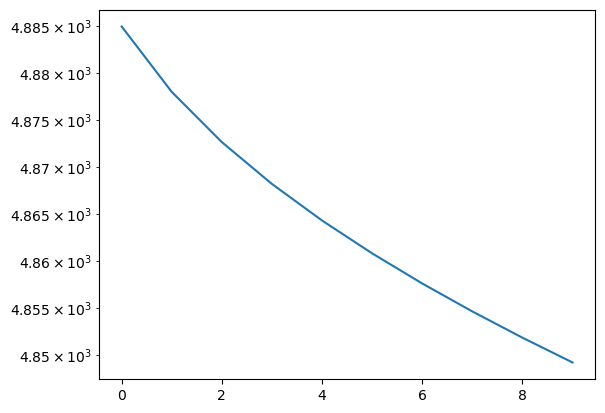

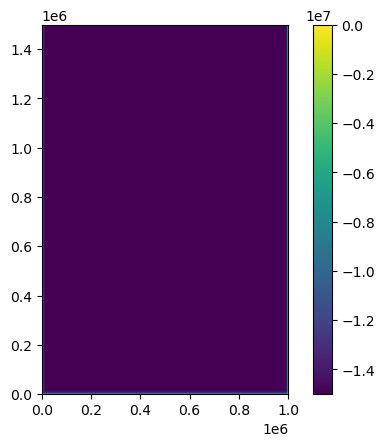

In [19]:
# Solve the same problem using gauss-seidel iterations.
theta = 1.5
s = zeros(nn,1) # boundary conditions are alredy satisfied

norm_store = []
function gauss_seidel(s::Matrix)
    residual = zeros(nn,1)
    coef_center = -2/dx^2-2/dy^2
    coef_right = 1/dx^2
    coef_left = 1/dx^2
    coef_up = 1/dy^2
    coef_down = 1/dy^2
    for iter in 1:10
        for j in 2:(nx-1)
            for i in 2:(ny-1)

                # in Gauss-Seidel iterations, the solution (s) is updated within each iteration.
                residual[dof(i,j)] = R[dof(i,j)] - coef_left*s[dof(i,j-1)] - coef_right*s[dof(i,j+1)] - coef_up*s[dof(i-1,j)] - coef_down*s[dof(i+1,j)] - coef_center*s[dof(i,j)]
                s[dof(i,j)] = s[dof(i,j)] + theta*residual[dof(i,j)]/coef_center
            end
        end
        append!(norm_store,norm(residual))
    end
    return s
end

sgs = gauss_seidel(s)

figure()
plot(norm_store)
gca().set_yscale("log")
show()

figure()
pcolor(x,y,reshape(sgs,ny,nx))
gca().set_aspect("equal")
colorbar()
show()

In [ ]:
using IterativeSolvers

@time s = gmres(L*dx^2, R*dx^2; restart = 200)

figure()
pcolor(x,y,reshape(s,ny,nx))
gca().set_aspect("equal")
colorbar()
show()

